Latent Dirichlet Allocation (LDA) is a widely used topic modelling technique that converts a set of documents into a set of topics. It helps us discover hidden semantic structures in the documents that we are dealing with, that allows us to learn topic representations of the corpus. 

Consider my tweets, I mostly tweet about economics, open science, text analysis. My topics might look like:

- Topic 1: Media Economics, Politics, Development 

- Topic 2: Open Data, Reproducibility, Code 

- Topic 3: NLP, Python, Machine Learning 

- Topic 4: Mental Health, Self Growth


In [1]:
import os
os.chdir("../../slides") #Change your directory here
from IPython.display import Image

In [2]:
Image(filename = "Figures/lda.png", width=800, height=900)

#### Each document is represented as a distribution over topics. Each topic is represented as a distribution over words.

There are 3 main things to remember:
- the number of topics
- the number of words per topic
- the number of topics per document

In [3]:
Image(filename = "Figures/ideal-topics.png", width=800, height=900)

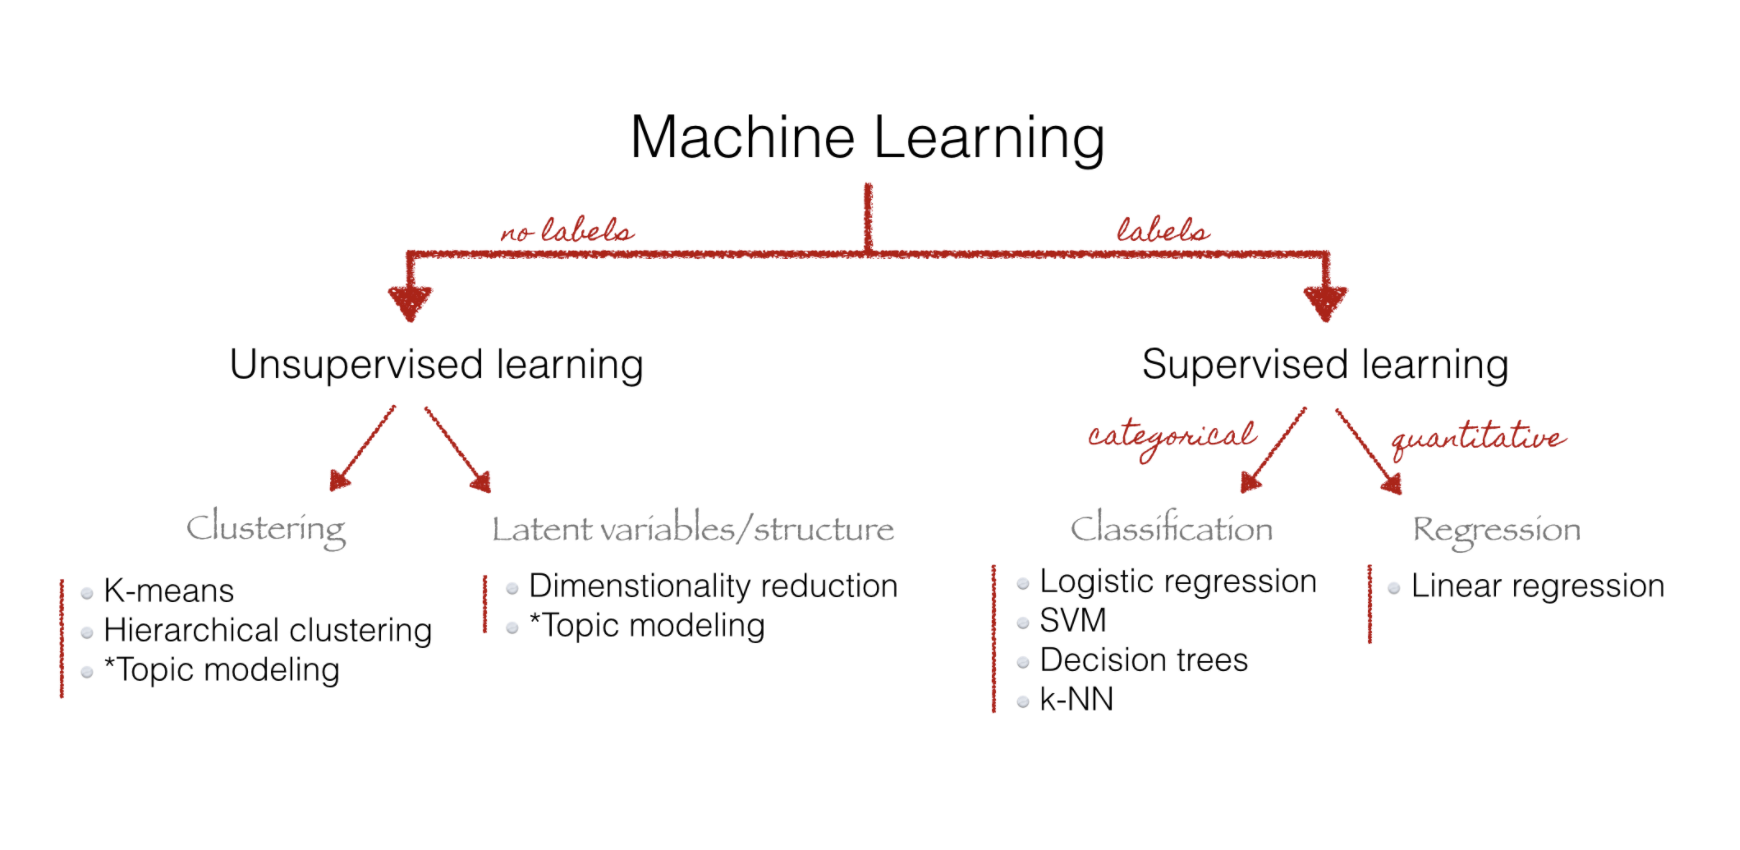

In [4]:
Image(filename = "Figures/ML.png", width=800, height=900)

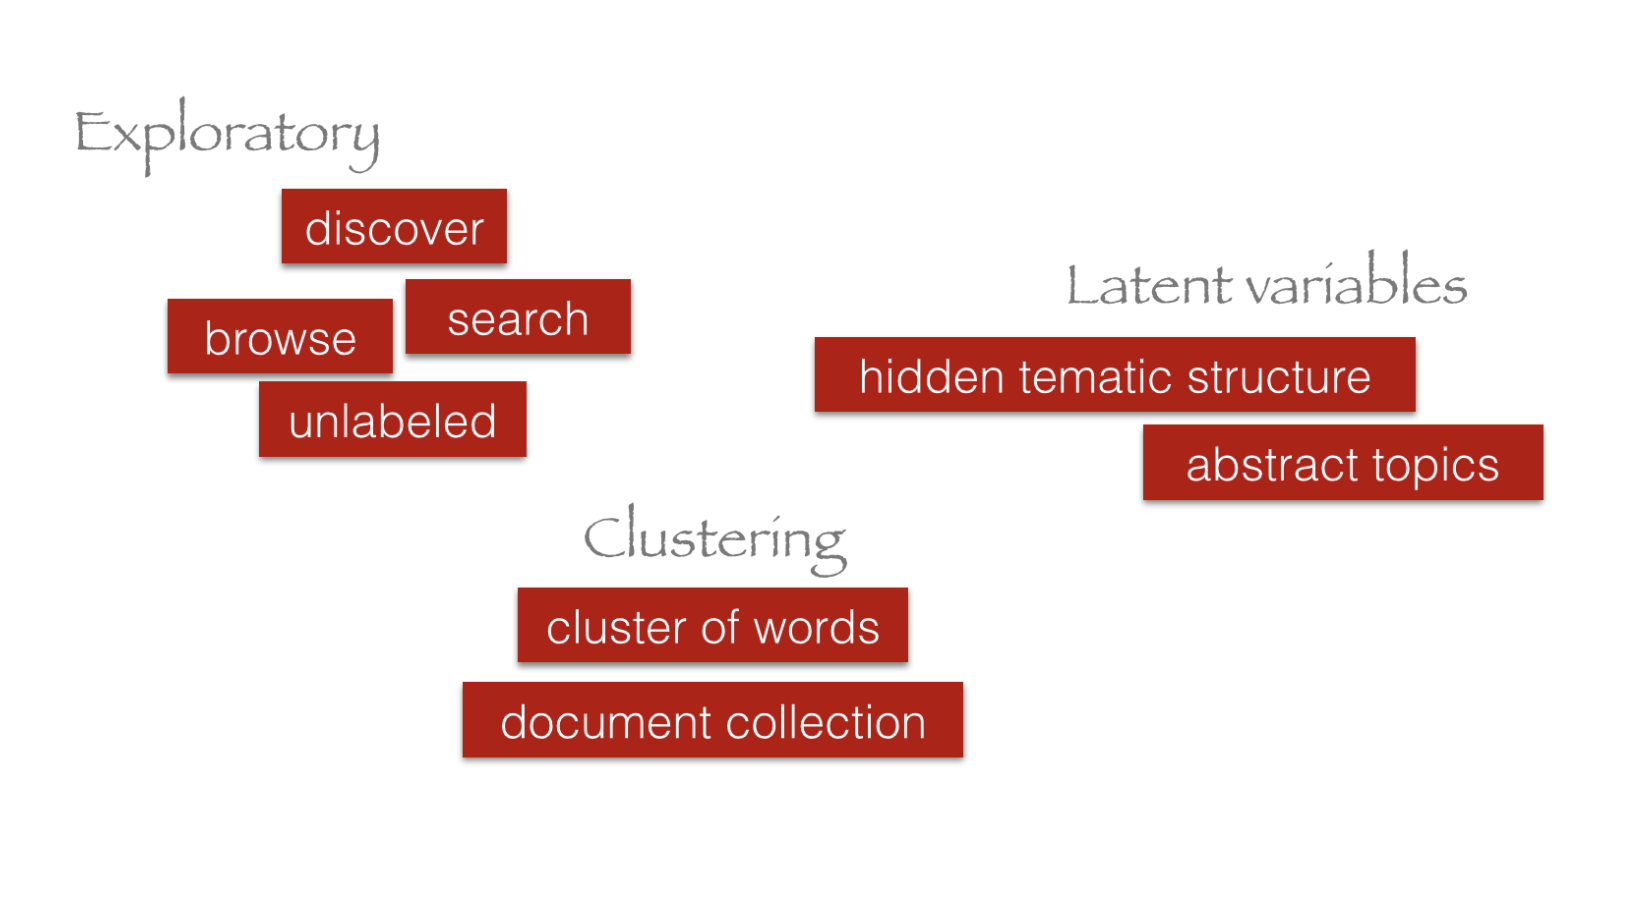

In [5]:
Image(filename = "Figures/char.png", width=800, height=900)

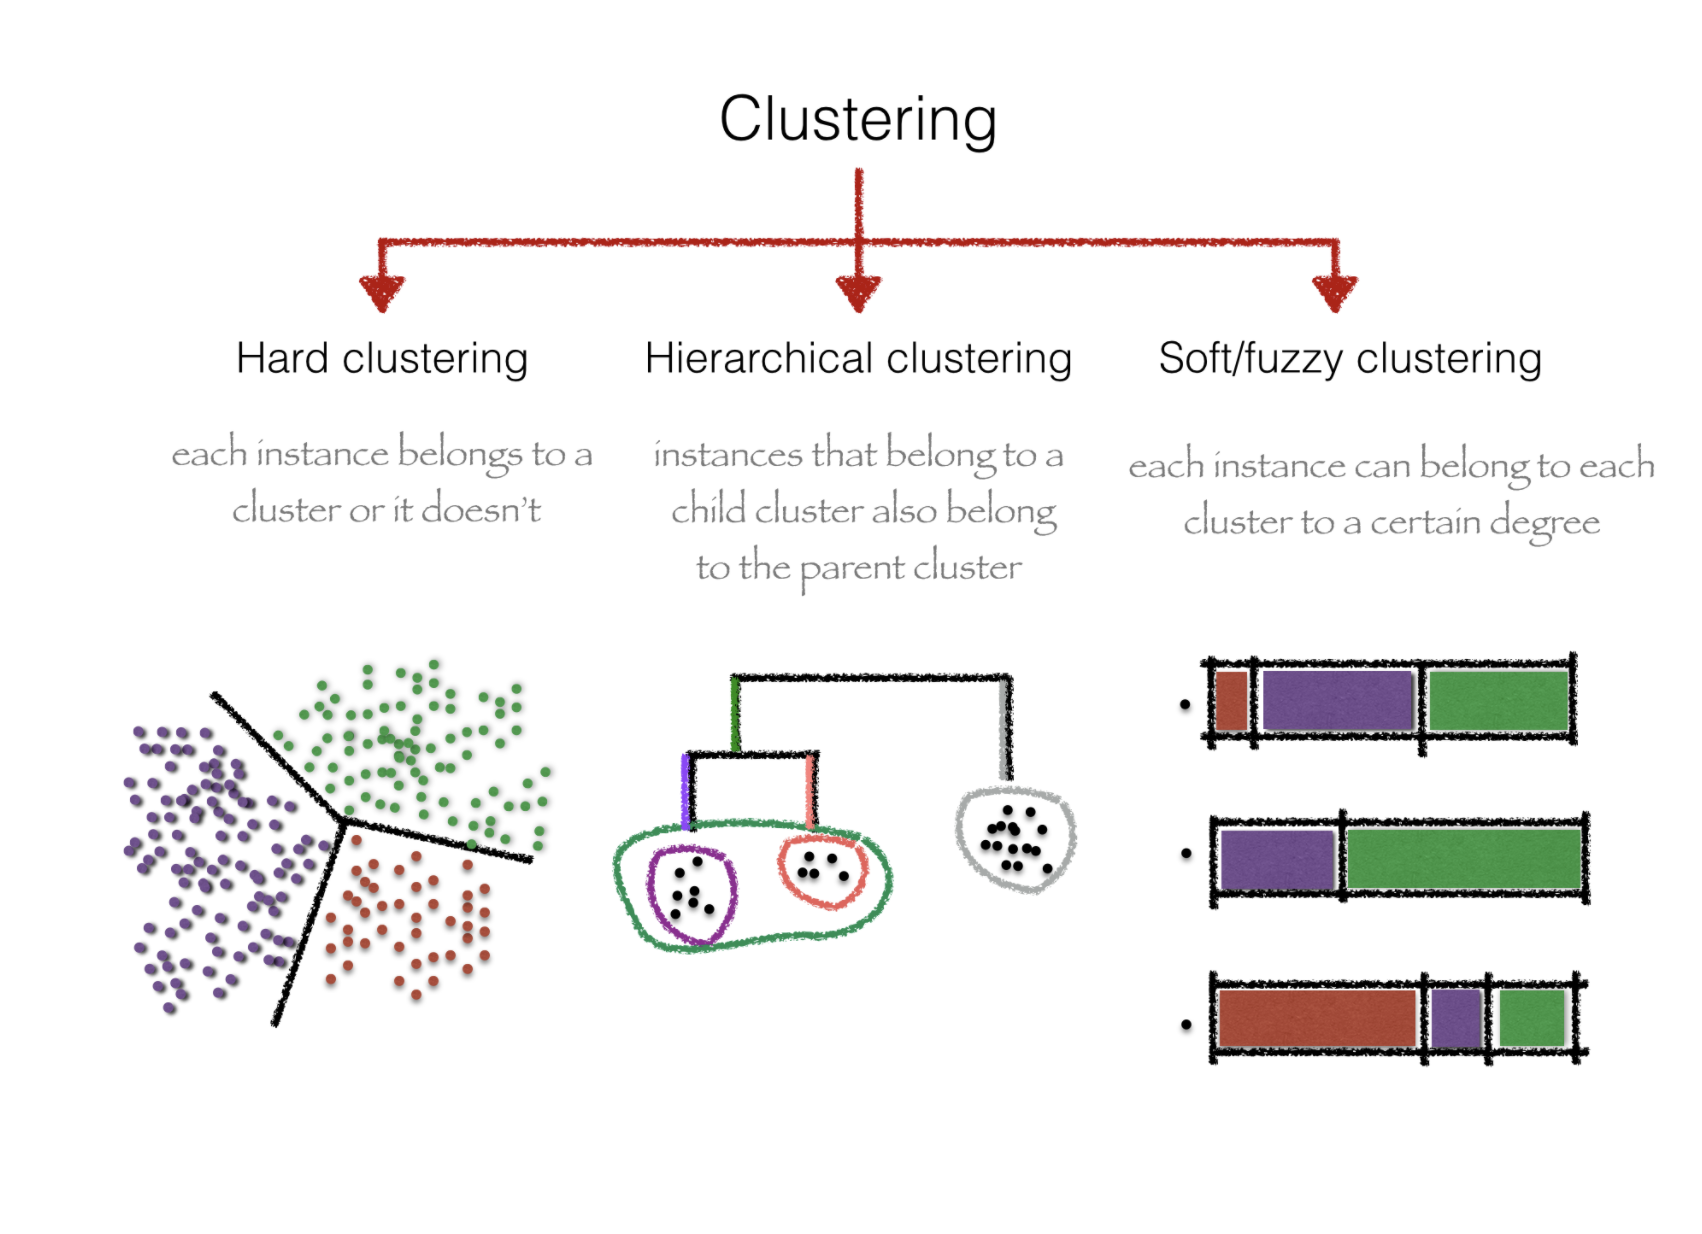

In [6]:
Image(filename = "Figures/topic_modelling.png", width=800, height=900)


Articles taken from BBC’s website. The original medium article can be found [here](https://towardsdatascience.com/the-complete-guide-for-topics-extraction-in-python-a6aaa6cedbbc) 

In [7]:
import pandas as pd 
data = pd.read_csv('../Inputs/articles_bbc_2018_01_30.csv')

In [8]:
data.head(10)

,articles,lang
0,Image copyright PA/EPA Image caption Oligarch ...,en
1,Husband admits killing French jogger\r\n\r\nTh...,en
2,Media playback is unsupported on your device M...,en
3,Manchester City's Leroy Sane is ruled out for ...,en
4,Image copyright AFP Image caption Sebastien Br...,en
5,The middle of nowhere\r\n\r\nFive miles from t...,en
6,Image copyright Reuters Image caption Mr Trump...,en
7,Putin says US list targets all Russians\r\n\r\...,en
8,Image copyright Getty Images\r\n\r\nIt is the ...,en
9,Image copyright Reuters Image caption The high...,en


In [9]:
data.describe

<bound method NDFrame.describe of                                               articles lang
0    Image copyright PA/EPA Image caption Oligarch ...   en
1    Husband admits killing French jogger\r\n\r\nTh...   en
2    Media playback is unsupported on your device M...   en
3    Manchester City's Leroy Sane is ruled out for ...   en
4    Image copyright AFP Image caption Sebastien Br...   en
..                                                 ...  ...
304  فيديو\r\n\r\nكيف تعبر الحدود...مثل الفيل؟!\r\n...   ar
305  بالصور\r\n\r\nمعالم لندن تحت الأضواء\r\n\r\nمع...   ar
306  يقدم لكم تلفزيون بي بي سي العربي الأخبار والأخ...   ar
307  موجات FM\r\n\r\nنبث إرسالنا على موجات إف إم في...   ar
308  Hi I am the head of product for BBC News Onlin...   en

[309 rows x 2 columns]>

In [10]:
data.shape

(309, 2)

In [11]:
data = data.dropna().reset_index(drop=True)

In [12]:
#!pip install langdetect

In [13]:
from langdetect import detect

In [14]:
data['language'] = data.articles.apply(lambda x: detect(x))

<AxesSubplot:>

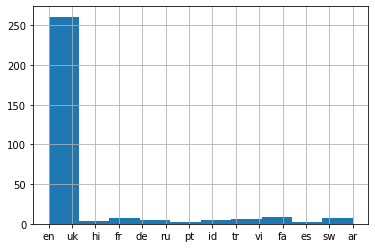

In [15]:
data.language.hist()

In [16]:
data.head()

,articles,lang,language
0,Image copyright PA/EPA Image caption Oligarch ...,en,en
1,Husband admits killing French jogger\r\n\r\nTh...,en,en
2,Media playback is unsupported on your device M...,en,en
3,Manchester City's Leroy Sane is ruled out for ...,en,en
4,Image copyright AFP Image caption Sebastien Br...,en,en


In [17]:
data.language.tolist()==data.lang.tolist()

False

In [18]:
data[data['lang'] != data['language']]

,articles,lang,language
55,Have Your Say,fr,en


In [19]:
data.iloc[55] 

articles    Have Your Say
lang                   fr
language               en
Name: 55, dtype: object

In [20]:
 data=data[data['language']=="en"]

In [21]:
 data.shape

(257, 3)

In [22]:
from nltk.tokenize import RegexpTokenizer
import re
tokenizer = RegexpTokenizer(r'\w+')
#alternative from nltk.tokenize import sent_tokenize

In [23]:
from nltk.corpus import stopwords
stopwords_verbs = ['say', 'get', 'go', 'know', 'may', 'need', 'like', 'make', 'see', 'want', 'come', 'take', 'use', 'would', 'can']
stopwords_other = ['one', 'mr', 'bbc', 'image', 'getty', 'de', 'en', 'caption', 'also', 'copyright', 'something']
my_stopwords = stopwords.words('English') + stopwords_verbs + stopwords_other

In [24]:
"say" in my_stopwords

True

In [25]:
def prepare_text_for_lda(text):
    text= re.sub(r'\d', '', text)
    tokens = tokenizer.tokenize(text.lower())
    return tokens

In [26]:
prepare_text_for_lda("Let's check if say is here. And what is that this is doing?.123")

['let',
 's',
 'check',
 'if',
 'say',
 'is',
 'here',
 'and',
 'what',
 'is',
 'that',
 'this',
 'is',
 'doing']

In [27]:
from nltk import pos_tag
pos_tag(['firms']) 

[('firms', 'NNS')]

In [28]:
from nltk.corpus import wordnet
# original example can be found here https://stackoverflow.com/a/15590384

def wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [29]:
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma(element):
    for word, pos in pos_tag(element.split()):
        result_pos=wordnet_pos(pos)
        if result_pos != None:
            return WordNetLemmatizer().lemmatize(word, result_pos)
        else:
            return word

In [30]:
get_lemma('went')

'go'

In [31]:
[get_lemma(word) for word in ["elements", "firms"]]

['element', 'firm']

In [32]:
data['tokens'] = data['articles'].apply(lambda x: prepare_text_for_lda(x))

In [33]:
data['tokens']

0      [image, copyright, pa, epa, image, caption, ol...
1      [husband, admits, killing, french, jogger, thr...
2      [media, playback, is, unsupported, on, your, d...
3      [manchester, city, s, leroy, sane, is, ruled, ...
4      [image, copyright, afp, image, caption, sebast...
                             ...                        
299    [image, copyright, getty, images, image, capti...
300    [the, key, piece, of, advice, do, the, writing...
301    [image, copyright, nasa, image, caption, nasa,...
302    [to, coincide, with, the, writersroom, comedy,...
307    [hi, i, am, the, head, of, product, for, bbc, ...
Name: tokens, Length: 257, dtype: object

In [34]:
def convert(list_element):
    tokens = [get_lemma(token) for token in list_element]
    tokens = [token for token in tokens if token not in my_stopwords]
    tokens = [token for token in tokens if len(token) > 3]
    return tokens

In [35]:
data['tokens'] = data['tokens'].apply(lambda sentences: convert(sentences))

## Bi-grams and tri-grams in Gensim

In [36]:
from gensim.models import Phrases
documents = ["the mayor of new york was there", 
             "machine learning can be useful sometimes",
             "new york mayor was present",
             "learning machine learning"]

sentence_stream = [doc.split(" ") for doc in documents]
bigram = Phrases(sentence_stream, min_count=1, threshold=2)

In [37]:
sent="let's try this text about new york mayor".split()

In [38]:
print(bigram[sent])

["let's", 'try', 'this', 'text', 'about', 'new_york', 'mayor']


In [39]:
sent2="machine learning text about new york mayor".split()

In [40]:
print(bigram[sent2])

['machine_learning', 'text', 'about', 'new_york', 'mayor']


In [41]:
sentence_stream

[['the', 'mayor', 'of', 'new', 'york', 'was', 'there'],
 ['machine', 'learning', 'can', 'be', 'useful', 'sometimes'],
 ['new', 'york', 'mayor', 'was', 'present'],
 ['learning', 'machine', 'learning']]

Prepare objects for LDA gensim implementation

In [42]:
from gensim import corpora

In [43]:
data['tokens']

0      [oligarch, roman, abramovich, dmitry, medvedev...
1      [husband, admits, kill, french, jogger, three,...
2      [medium, playback, unsupported, device, medium...
3      [manchester, city, leroy, sane, rule, seven, w...
4      [sebastien, famed, restaurant, father, michel,...
                             ...                        
299    [could, robot, harm, human, science, fiction, ...
300    [piece, advice, write, write, unstoppable, muc...
301    [nasa, nasa, develops, design, computer, long,...
302    [coincide, writersroom, comedy, submission, wi...
307    [head, product, news, online, lead, product, s...
Name: tokens, Length: 257, dtype: object

In [44]:
data['tokens'].tolist()

[['oligarch',
  'roman',
  'abramovich',
  'dmitry',
  'medvedev',
  'list',
  'russian',
  'president',
  'vladimir',
  'putin',
  'list',
  'official',
  'businessmen',
  'close',
  'kremlin',
  'publish',
  'effect',
  'target',
  'russian',
  'people',
  'list',
  'name',
  'russian',
  'part',
  'sanction',
  'punish',
  'moscow',
  'meddling',
  'election',
  'however',
  'stress',
  'name',
  'subject',
  'sanction',
  'putin',
  'list',
  'unfriendly',
  'complicate',
  'russia',
  'escalate',
  'situation',
  'putin',
  'russia',
  'instead',
  'think',
  'economy',
  'list',
  'deride',
  'number',
  'senior',
  'russian',
  'official',
  'bore',
  'strong',
  'resemblance',
  'forbes',
  'magazine',
  'rank',
  'russian',
  'billionaire',
  'treasury',
  'department',
  'later',
  'told',
  'buzzfeed',
  'unclassified',
  'annex',
  'report',
  'derive',
  'magazine',
  'publish',
  'list',
  'government',
  'require',
  'draw',
  'list',
  'congress',
  'pass',
  'counter',

In [45]:
dictionary_LDA = corpora.Dictionary(data['tokens'].tolist())

In [46]:
print(dictionary_LDA)

Dictionary(8661 unique tokens: ['abramovich', 'accepted', 'accuse', 'action', 'activity']...)


In [47]:
"say" in data['tokens'].tolist()[0]

False

In [48]:
dictionary_LDA.filter_extremes(no_below=3)

In [49]:
"say" in dictionary_LDA

False

In [50]:
corpus = [dictionary_LDA.doc2bow(tok) for tok in data['tokens'].tolist()]

## Running LDA

In [51]:
from gensim import models
import numpy as np

In [52]:
np.random.seed(123)
num_topics = 10
lda_model = models.LdaModel(corpus, num_topics=num_topics, 
                                  id2word=dictionary_LDA, 
                                  passes=4)

In [53]:

for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=20):
    print(str(i)+": "+ topic + "\n")


0: 0.014*"wave" + 0.008*"time" + 0.008*"year" + 0.008*"world" + 0.007*"drug" + 0.006*"people" + 0.006*"show" + 0.006*"could" + 0.006*"ocean" + 0.005*"town" + 0.005*"city" + 0.005*"game" + 0.005*"water" + 0.005*"kick" + 0.004*"call" + 0.004*"help" + 0.004*"life" + 0.004*"travel" + 0.004*"look" + 0.003*"back"

1: 0.015*"list" + 0.014*"sanction" + 0.012*"russia" + 0.011*"light" + 0.010*"russian" + 0.008*"report" + 0.008*"could" + 0.008*"putin" + 0.008*"transparent" + 0.008*"president" + 0.007*"name" + 0.006*"trump" + 0.006*"animal" + 0.006*"system" + 0.005*"news" + 0.005*"predator" + 0.005*"election" + 0.005*"kremlin" + 0.005*"call" + 0.005*"live"

2: 0.009*"year" + 0.008*"first" + 0.007*"trump" + 0.006*"people" + 0.006*"think" + 0.006*"back" + 0.006*"test" + 0.006*"time" + 0.005*"president" + 0.005*"government" + 0.005*"told" + 0.005*"company" + 0.005*"could" + 0.004*"thing" + 0.004*"look" + 0.004*"brexit" + 0.004*"minister" + 0.004*"call" + 0.004*"food" + 0.004*"world"

3: 0.010*"year" 

In [54]:
print(data.articles.loc[0][:500])

Image copyright PA/EPA Image caption Oligarch Roman Abramovich (l) and PM Dmitry Medvedev are on the list

Russian President Vladimir Putin says a list of officials and businessmen close to the Kremlin published by the US has in effect targeted all Russian people.

The list names 210 top Russians as part of a sanctions law aimed at punishing Moscow for meddling in the US election.

However, the US stressed those named were not subject to new sanctions.

Mr Putin said the list was an unfr


In [55]:
lda_model[corpus[0]]

[(1, 0.997674)]

##Predicting topics on unseen text

In [56]:
new_document = """The Kremlin denied on Thursday there was anything untoward with Russia’s official coronavirus death data 
after the World Health Organisation said
this week that Russia’s low death rate was "difficult to understand."
""" 

In [57]:
tokens = prepare_text_for_lda(new_document)

In [58]:
topics = lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=20)


In [59]:
lda_model[dictionary_LDA.doc2bow(tokens)]

[(1, 0.4081771), (4, 0.08182005), (9, 0.4687981)]

In [60]:
pd.DataFrame([(el[0], round(el[1],2),
               topics[el[0]][1]) for el in lda_model[dictionary_LDA.doc2bow(tokens)]],
             columns=['topic #', 'weight', 'words in topic'])

,topic #,weight,words in topic
0,1,0.41,"0.015*""list"" + 0.014*""sanction"" + 0.012*""russi..."
1,4,0.08,"0.011*""dutch"" + 0.008*""design"" + 0.008*""instag..."
2,9,0.47,"0.011*""work"" + 0.009*""case"" + 0.008*""help"" + 0..."


In [61]:
## Advanced exploration of LDA results. Allocation of topics in all documents

In [62]:
topics = [lda_model[corpus[i]] for i in range(len(data))]

def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res


In [63]:
document_topic = pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in topics]).reset_index(drop=True).fillna(0)

In [64]:
document_topic

,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.997674,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.935694,0.000000,0.000000,0.000000
2,0.995733,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.670363,0.011116,0.011117,0.011114,0.011117,0.011114,0.011115,0.011117,0.011115,0.240712
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.996310,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
252,0.000000,0.997661,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
253,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.987495,0.000000
254,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.992171
255,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.996469,0.000000,0.000000


In [65]:
# Which document are about topic 2
document_topic.sort_values(2, ascending=False)[2].head(20)

66     0.997721
79     0.996968
171    0.996968
248    0.996927
63     0.996185
186    0.996051
19     0.995962
95     0.995106
62     0.994970
103    0.991505
172    0.989650
160    0.976915
231    0.966652
193    0.964562
191    0.963399
222    0.960852
141    0.939966
184    0.933278
167    0.931776
25     0.918150
Name: 2, dtype: float64

In [66]:
print(data.articles.iloc[82][0:1000])

Image copyright Rex Features Image caption Simon Thomas said his wife Gemma died 'surrounded by family and friends'

Sky Sports anchor Simon Thomas has said he is weak with grief and unsure how he will ever return to his career.

Since his wife Gemma died suddenly last year aged 40, Thomas said the message from others had been to "be strong".

But writing in a blog post, the former Blue Peter presenter said he is broken, fearful, vulnerable and tear-filled and "if by admitting this it helps one person, then it's worth it".

The post has been praised for its "astonishing honesty" and courage.

Gemma died last November just three days after she was diagnosed with acute myeloid leukaemia.

Thomas has since shared his struggles with grief and supporting their eight-year-old son Ethan.

In his latest post, written in the early hours of Monday morning in the "tenth week of severe sleep deprivation", Thomas reflects on the words of author and pastor, Pete Greig.

"Don't be str


<AxesSubplot:>

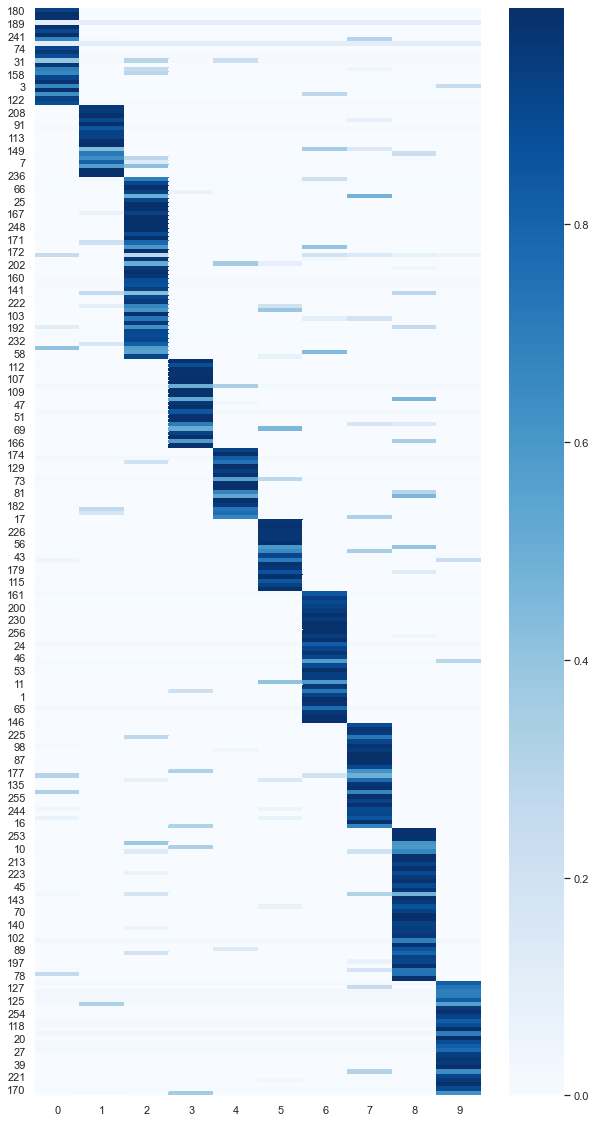

In [67]:
##Looking at the distribution of topics in all documents
import seaborn as sns
sns.set(rc={'figure.figsize':(10,20)})
sns.heatmap(document_topic.loc[document_topic.idxmax(axis=1).sort_values().index], cmap="Blues")

<AxesSubplot:>

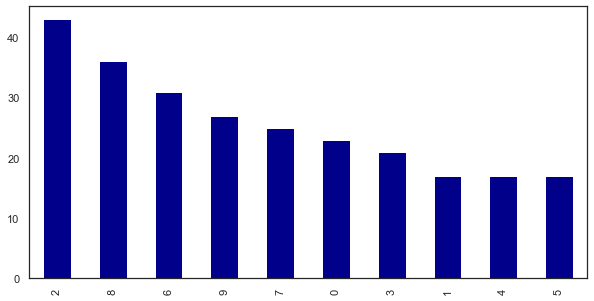

In [68]:
sns.set(rc={'figure.figsize':(10,5)})
sns.set_style("white") 
document_topic.idxmax(axis=1).value_counts().plot.bar(color='darkblue')

In [69]:

# https://cran.r-project.org/web/packages/LDAvis/vignettes/details.pdf
# Here a short legend to explain the vis:
# size of bubble: proportional to the proportions of the topics across the N total tokens in the corpus
# red bars: estimated number of times a given term was generated by a given topic
# blue bars: overall frequency of each term in the corpus
# -- Relevance of words is computed with a parameter lambda
# -- Lambda optimal value ~0.6 (https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf)
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.display(vis)

/Users/ariedamuco/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps
/Users/ariedamuco/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [70]:
#!pip install pyLDAvis

/Users/ariedamuco/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### References 

Heavily based on 

https://github.com/FelixChop/MediumArticles/blob/master/LDA-BBC.ipynb

https://towardsdatascience.com/the-complete-guide-for-topics-extraction-in-python-a6aaa6cedbbc

and material from Christine Doig

https://www.youtube.com/watch?v=BuMu-bdoVrU


Matti Lyra

https://github.com/mattilyra/pydataberlin-2017


Other references

http://en.wikipedia.org/wiki/Topic_model

http://www.cs.columbia.edu/~blei/papers/Blei2012.pdf

http://mallet.cs.umass.edu/topics.php